In [1]:
# nb to test each step of tead with an example model with goal
# of setting up tead to work with botorch MCAcquisitionFunction

In [2]:
import torch
dtype = torch.double
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_mll
from botorch.models.transforms import Normalize, Standardize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

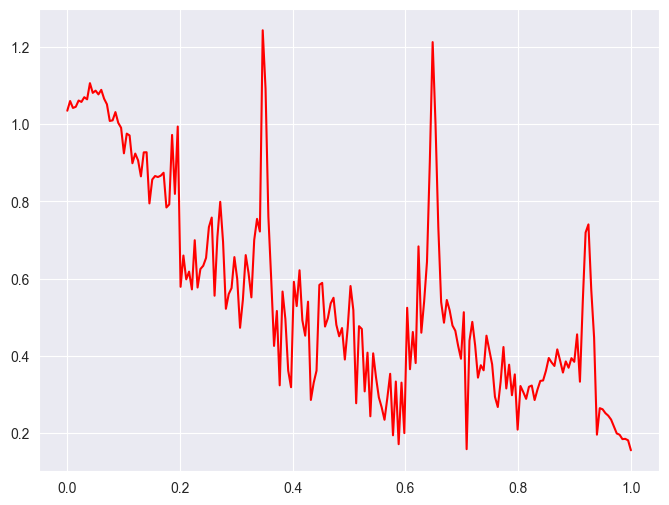

In [76]:
# canonical problem
def mme_noise_jump_1d_mean(x):
    y = torch.zeros(x.shape)
    y += 0.66*(-1.*x + 0.1*torch.sin(30.*x) + torch.exp(-(100.*(x-0.65))**2.)) * (x >= 0.6)
    y += 0.66*(-1.*x + 0.1*torch.sin(30.*x) - 0.25 + torch.exp(-(100.*(x-0.65))**2.)) * (x < 0.6) * (x >= 0.2)
    y += 0.66*(-1.*x + 0.1*torch.sin(30.*x) + 0.2 + torch.exp(-(100.*(x-0.65))**2.)) * (x < 0.2)
    y += 0.7 * ( torch.exp(-(100.*(x-0.35))**2.) )
    y += 0.4 * ( torch.exp(-(100.*(x-0.92))**2.) )
    y += 0.9
    return y


sigma_max = torch.tensor(0.12, dtype=dtype)
sigma_min = torch.tensor(0.02, dtype=dtype)


def mme_noise_jump_1d(x):
    # mean
    y = mme_noise_jump_1d_mean(x)
    # noise
    noise = torch.zeros(x.shape)
    noise += (torch.randn(x.shape) * sigma_max) * (x >= 0.61) * (x < 0.71)
    noise += (torch.randn(x.shape) * 0.5*sigma_max) * (x >= 0.31) * (x < 0.41)
    noise += (torch.randn(x.shape) * 0.8*sigma_max) * (x >= 0.90) * (x < 0.94)
    noise += (torch.randn(x.shape) * (sigma_max - sigma_min) / (1. + torch.exp(-10.*(x-0.2))) )* (x < 0.61)
    noise += (torch.randn(x.shape) * (sigma_max - sigma_min) / (1. + torch.exp(10.*(x-0.75))) ) * (x >= 0.71)
    # combined
    y_out = y + noise
    # any_neg = y_out < 0
    # if any_neg:
    #     y_out = torch.tensor(0.0)
    return y_out

def outcome_objective(x):
    """wrapper for the outcome objective function"""
    # return mme_torch(X).type_as(X)
    return mme_noise_jump_1d(x).type_as(x)

x1 = torch.linspace(0,1.0,200)
y1 = mme_noise_jump_1d(x1)
fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.lineplot(x=x1, y=y1, ax=ax, color='r')
# plt.savefig(datasavedir + '/'+'full_test_problem_one_realization'+'.png')
None

In [84]:
train_X = torch.rand(20,1, dtype=dtype)
train_Y = outcome_objective(train_X)
model_example = SingleTaskGP(train_X, train_Y,
                             input_transform=Normalize(d=train_X.shape[-1]),
                             outcome_transform=Standardize(m=train_Y.shape[-1]))
mll_example = ExactMarginalLogLikelihood(model_example.likelihood, model_example)
fitting = fit_gpytorch_mll(mll_example)

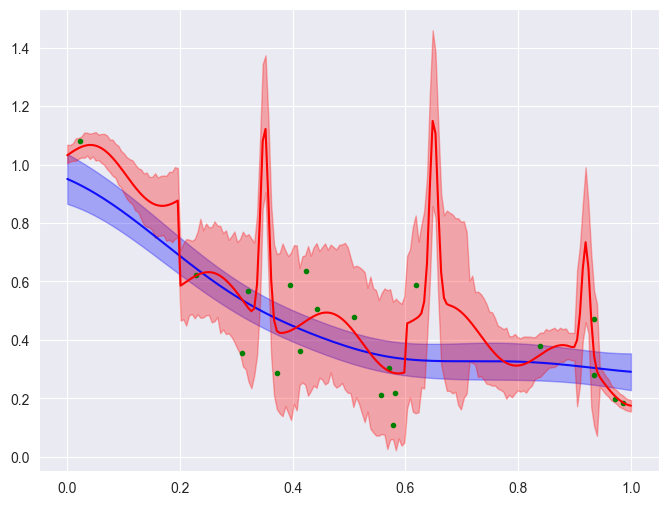

In [89]:

fig, ax = plt.subplots(1,1, figsize=(8,6))
x_plot = torch.linspace(0,1,200).unsqueeze(-1)
model_posterior = model_example.posterior(x_plot, observation_noise=True)
# model_posterior = model_example.posterior(x_plot, observation_noise=False)
mean_ex = model_posterior.mean.detach().squeeze().numpy()
ax.plot(x_plot.numpy(),mean_ex,'b-', alpha=0.9)
var_ex = model_posterior.variance.detach().squeeze().numpy()
sd_ex = np.sqrt(var_ex)
up_ex = mean_ex + 2.0 * var_ex
lo_ex = mean_ex - 2.0 * var_ex
ax.fill_between(x_plot.squeeze().numpy(), lo_ex, up_ex, color='b', alpha=0.3)
ax.plot(train_X.numpy(), train_Y.numpy(), 'g.')


num_reals = 500
num_x = 200
x1 = torch.linspace(0,1.0,num_x)
y_reps = torch.DoubleTensor(num_x, num_reals)
y_deter = mme_noise_jump_1d_mean(x1)
for i in range(num_reals):
    y_reps[:,i] = mme_noise_jump_1d(x1)

sns.lineplot(x=x1, y=y_deter, ax=ax, color='r')
upper_99 = torch.quantile(y_reps, 0.995, dim=1)
lower_01 = torch.quantile(y_reps, 0.005, dim=1)
ax.fill_between(x1, lower_01, upper_99, color='r', alpha=0.3, label=r'99% quantiles')

In [90]:
def nfinite_diff(model):
    """get approx gradient at model training points"""
    # assumes 1d output... see implementation in [3] for update to n-D
    h = 1e-4
    x = model.input_transform.untransform(model.train_inputs[0])
    num_data = x.shape[0]
    num_dim = x.shape[1]
    delta_s = torch.zeros(num_data, num_dim)
    for i in range(0, num_data):
        for j in range(0, num_dim):
            dx = torch.zeros(1, num_dim)
            dx[:,j] = h  # set the dimension for the gradient to have a step
            x_lo = x[i] - dx  # element-wise subtract
            x_hi = x[i] + dx  # element-wise addition
            # x_lo = model.input_transform.transform(x_lo)
            # x_hi = model.input_transform.transform(x_hi)
            y_lo = model(x_lo.unsqueeze(0)).mean  # unsqueeze to match model syntax
            y_hi = model(x_hi.unsqueeze(0)).mean  # unsqueeze to match model syntax
            delta_s[i, j] = (y_hi - y_lo)/(2*h)
    return delta_s

custom_grad = nfinite_diff(model_example)

C:\Users\alexb\AppData\Local\Temp\ipykernel_19132\867195554.py:4: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten\src\ATen/core/TensorBody.h:491.)
  model_posterior.mean.grad()


TypeError: 'NoneType' object is not callable

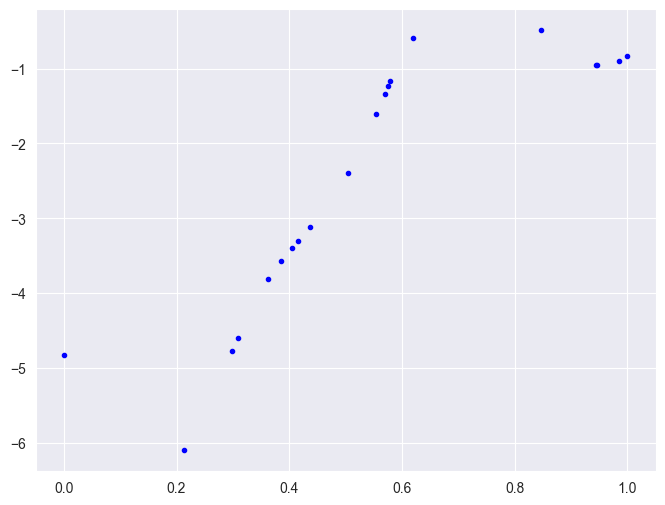

In [91]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(model_example.train_inputs[0].detach().numpy(), nfinite_diff(model_example).detach().numpy(), 'b.')

model_posterior.mean.grad()

In [92]:
x_grad = torch.linspace(0,1,100).unsqueeze(-1)
x_grad.requires_grad = True
y_grad = model_example.posterior(x_grad).mean
grad_gp = torch.autograd.grad(y_grad,x_grad,
                              torch.ones_like(y_grad),retain_graph=True)[0]

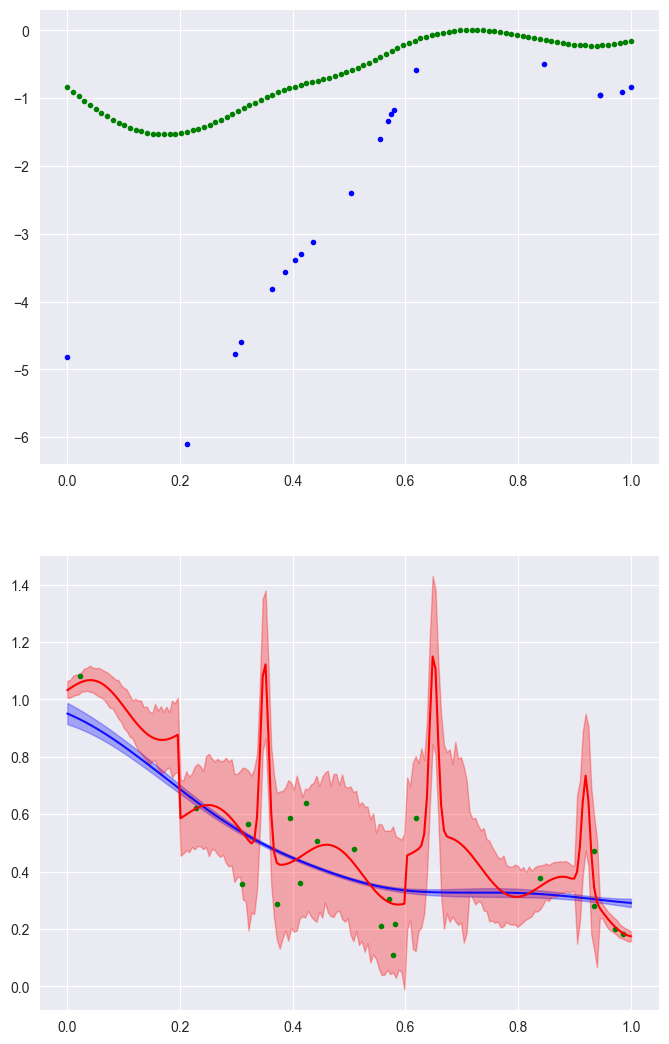

In [93]:
fig, ax = plt.subplots(2,1, figsize=(8,13))
ax = ax.ravel()
ax[0].plot(model_example.train_inputs[0].detach().numpy(), nfinite_diff(model_example).detach().numpy(), 'b.')
ax[0].plot(x_grad.detach(),grad_gp.detach(), 'g.')

x_plot = torch.linspace(0,1,200).unsqueeze(-1)
model_posterior = model_example.posterior(x_plot, observation_noise=True)
model_posterior = model_example.posterior(x_plot, observation_noise=False)
mean_ex = model_posterior.mean.detach().squeeze().numpy()
ax[1].plot(x_plot.numpy(),mean_ex,'b-', alpha=0.9)
var_ex = model_posterior.variance.detach().squeeze().numpy()
sd_ex = np.sqrt(var_ex)
up_ex = mean_ex + 2.0 * var_ex
lo_ex = mean_ex - 2.0 * var_ex
ax[1].fill_between(x_plot.squeeze().numpy(), lo_ex, up_ex, color='b', alpha=0.3)
ax[1].plot(train_X.numpy(), train_Y.numpy(), 'g.')


num_reals = 500
num_x = 200
x1 = torch.linspace(0,1.0,num_x)
y_reps = torch.DoubleTensor(num_x, num_reals)
y_deter = mme_noise_jump_1d_mean(x1)
for i in range(num_reals):
    y_reps[:,i] = mme_noise_jump_1d(x1)

sns.lineplot(x=x1, y=y_deter, ax=ax[1], color='r')
upper_99 = torch.quantile(y_reps, 0.995, dim=1)
lower_01 = torch.quantile(y_reps, 0.005, dim=1)
ax[1].fill_between(x1, lower_01, upper_99, color='r', alpha=0.3, label=r'99% quantiles')

In [94]:
# setting up each step in tead with functions changed to format for q tead

# get model and x data points
tead_model = model_example
x_data = tead_model.input_transform.untransform(tead_model.train_inputs[0])

In [95]:
# set the x data to calculate gradients
x_data.requires_grad = True

In [96]:
# get the gradients of the GP at the x data points
# may need to make this more fancy if this second call to posterior is expensive
y_data_grad = model_example.posterior(x_data).mean
grads = torch.autograd.grad(y_data_grad,x_data,
                              torch.ones_like(y_data_grad),retain_graph=True)[0]

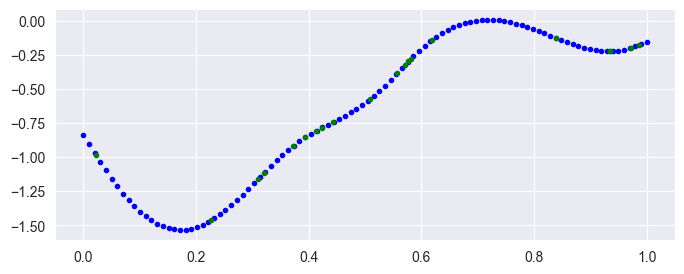

In [101]:
# plot grads to check match
fig, ax = plt.subplots(1,1, figsize=(8,3))
ax.plot(x_grad.detach(),grad_gp.detach(), 'b.')
ax.plot(x_data.detach(),grads.detach(), 'g.')
None

In [ ]:
# now, what does X look like as an input to qEI or qNEI? want to 
# duplicate that here instead of doing LHS candidates as in TEAD

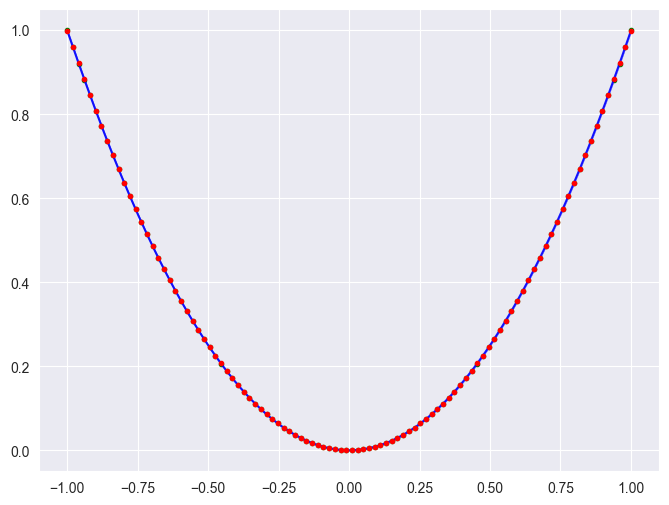

In [67]:
# set up an example y=x^2
train_X=torch.linspace(-1,1,100, dtype=dtype).unsqueeze(-1)
train_Y = train_X * train_X


model_test = SingleTaskGP(train_X, train_Y,
                             input_transform=Normalize(d=train_X.shape[-1]),
                             outcome_transform=Standardize(m=train_Y.shape[-1]))
mll_test = ExactMarginalLogLikelihood(model_test.likelihood, model_test)
fitting = fit_gpytorch_mll(mll_test)

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(train_X.detach().numpy(), train_Y.detach().numpy(), 'g.')

x_plot = torch.linspace(-1,1,200).unsqueeze(-1)
model_posterior = model_test.posterior(x_plot, observation_noise=True)
mean_ex = model_posterior.mean.detach().squeeze().numpy()
ax.plot(x_plot.numpy(),mean_ex,'b-', alpha=0.9)
var_ex = model_posterior.variance.detach().squeeze().numpy()
sd_ex = np.sqrt(var_ex)
up_ex = mean_ex + 2.0 * var_ex
lo_ex = mean_ex - 2.0 * var_ex
ax.fill_between(x_plot.squeeze().numpy(), lo_ex, up_ex, color='b', alpha=0.3)

ax.plot(model_test.input_transform.untransform(model_test.train_inputs[0]),
        model_test.posterior(model_test.input_transform.untransform(model_test.train_inputs[0])).mean.detach(), 'r.')

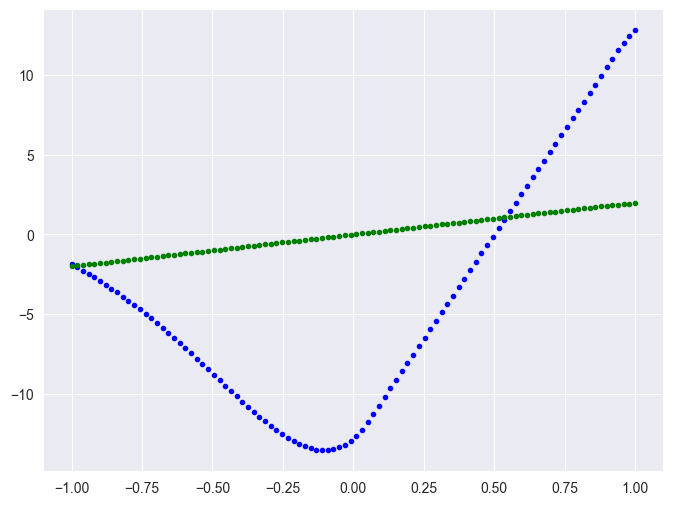

In [71]:
x_grad = torch.linspace(-1,1,100).unsqueeze(-1)
x_grad.requires_grad = True
y_grad = model_test.posterior(x_grad).mean
grad_gp = torch.autograd.grad(y_grad,x_grad,
                              torch.ones_like(y_grad),
                              retain_graph=True)[0]

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(model_test.input_transform.untransform(model_test.train_inputs[0]).detach().numpy(), nfinite_diff(model_test).detach().numpy(), 'b.')
ax.plot(x_grad.detach(),grad_gp.detach(), 'g.')

In [57]:
model_test.input_transform.untransform(model_test.train_inputs[0])

tensor([[-1.0000],
        [-0.9798],
        [-0.9596],
        [-0.9394],
        [-0.9192],
        [-0.8990],
        [-0.8788],
        [-0.8586],
        [-0.8384],
        [-0.8182],
        [-0.7980],
        [-0.7778],
        [-0.7576],
        [-0.7374],
        [-0.7172],
        [-0.6970],
        [-0.6768],
        [-0.6566],
        [-0.6364],
        [-0.6162],
        [-0.5960],
        [-0.5758],
        [-0.5556],
        [-0.5354],
        [-0.5152],
        [-0.4949],
        [-0.4747],
        [-0.4545],
        [-0.4343],
        [-0.4141],
        [-0.3939],
        [-0.3737],
        [-0.3535],
        [-0.3333],
        [-0.3131],
        [-0.2929],
        [-0.2727],
        [-0.2525],
        [-0.2323],
        [-0.2121],
        [-0.1919],
        [-0.1717],
        [-0.1515],
        [-0.1313],
        [-0.1111],
        [-0.0909],
        [-0.0707],
        [-0.0505],
        [-0.0303],
        [-0.0101],
        [ 0.0101],
        [ 0.0303],
        [ 0.